# Description
- task:
    - create an accurate simulator of IMC's engine
    - inputs:
        - previous market orders
        - fair price
        - my orders
        - previous trades?
        - my positions (hence market positions)
    - outputs:
        - new market trades
        - new my trades
        - new order book
    - loss functions?
        - imitation learning (directly copy actions)
        
- approaches:
    - treat products independently
    - simplify inputs by being stateless 
        - ignore inventory
        - ignore previous market orders
        - ignore other products
        - only consider:
            - fair value
            - my orders
            - market orders
            
## Simulate market orders
    - preprocessing
        - normalize all prices to 0 (fair = mid of large quotes)
        - 
    - inputs:
        - "fair price" (normalized)
    - outputs:
        - "quotes" (normalized)
    - comparison?
        - GANs
        a
        

## GAN

- keras 2.11.0
- tensorflow 2.11.0

In [1]:
# standard data libaries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

# dataset
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import KFold

# error bar
# from tqdm import tqdm
from tqdm.auto import trange, tqdm

# layers
from tensorflow.keras import layers, optimizers


In [73]:
def build_generator():
    # initializing the neural network
    generator = keras.Sequential(
        [
            layers.InputLayer(input_shape=(100,)),
            layers.Dense(units=256),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(units=256),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(units=784, activation="tanh"),
        ],
        name="generator",
    )

    return generator

In [74]:
def build_discriminator():
    #initializing a neural network
    discriminator = keras.Sequential(
        [
            layers.InputLayer(input_shape=(784,)),
            layers.Dense(256),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(256),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(units=1, activation="sigmoid"),
        ],
        name="discriminator",
    )
    
    return discriminator

In [75]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, data):
        # get real images
        imgs_real = data
        
        """ train discriminator """
        
        # sample points in latent space
        batch_size = tf.shape(imgs_real)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # get fake images from generator using latent vectors as input
        imgs_fake = self.generator(noise)
        
        imgs_all = tf.concat([imgs_fake, imgs_real], axis=0)
        
        # create labels for real/fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        
        # train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(imgs_all)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        """ train generator """
        
        # sample points in latent space
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # create "misleading" labels for generator training
        g_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            imgs_mid = self.generator(noise)
            predictions = self.discriminator(imgs_mid)
            g_loss = self.loss_fn(g_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        # track loss
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        
        return {
            "g_loss": g_loss,
            "d_loss": d_loss,
        }

In [76]:
discriminator = build_discriminator()
generator = build_generator()

gan = GAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=100,
)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [77]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape/normalize X_train
X_train = np.reshape(X_train, (len(X_train), 784))
X_train=(X_train.astype(np.float32)-127.5)/127.5

In [92]:
gan.fit(
    x=X_train, 
    batch_size=256,
    epochs=100,
    shuffle=True,
    workers=16,
    use_multiprocessing=True,
)

Epoch 1/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.7877 - d_loss: 0.4269
Epoch 2/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.8307 - d_loss: 0.4294
Epoch 3/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.8540 - d_loss: 0.4292
Epoch 4/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.8207 - d_loss: 0.4287
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.7978 - d_loss: 0.4306
Epoch 6/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.8203 - d_loss: 0.4282
Epoch 7/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.7783 - d_loss: 0.4267
Epoch 8/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.7972 - d_loss: 0.4251
Epoch 9/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.8297 - d_loss: 0.4285
Epoch 10/100
235/235 [==============================] - 2s 10ms/step - g_loss: 1.8

(50, 28, 28)


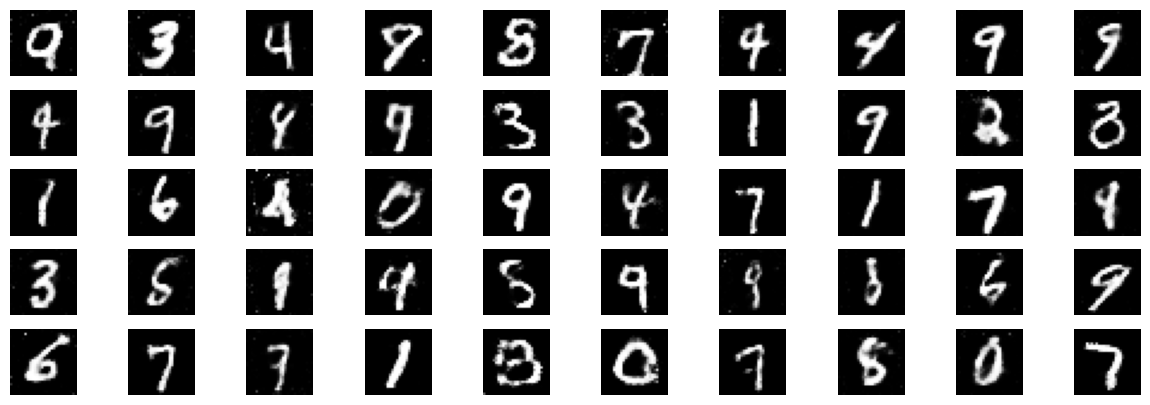

In [94]:
self = gan
dim = (5, 10)
figsize = (15, 5)

n_samples = dim[0] * dim[1]

# create noise for sample imgs
noise=np.random.normal(loc=0,scale=1,size=[n_samples, self.latent_dim])

# generate imgs from noise
imgs = self.generator(noise)
imgs = tf.reshape(imgs, (n_samples, 28, 28))

print(imgs.shape)

plt.figure(figsize=figsize)
for i in range(imgs.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(imgs[i], cmap="gray")
    plt.axis("off")
    # plt.tight_layout()
    
plt.show()

In [ ]:
import sys
sys.path.append("..")

from nbs.log_parser import process_file

In [ ]:
import pathlib
from pathlib import Path


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
_replay_folder = "../replays/train"

In [ ]:
folder_path = Path(_replay_folder)
fnames = list(path.iterdir())
fnames

In [ ]:
state_data = []
order_data = []

for game_id, fname in enumerate(fnames):
    state_obj = process_file(fname, start_sep="__game_state_start", end_sep="__game_state_end")
    order_obj = process_file(fname, start_sep="__turn_end_start", end_sep="__turn_end_end")
    
    state_df = pd.DataFrame(state_obj)
    state_df["game_id"] = game_id
    order_df = pd.DataFrame(order_obj)
    order_df["game_id"] = game_id
    
    state_data += [state_df]
    order_data += [order_df]

state_df = pd.concat(state_data, axis=0)
order_df = pd.concat(order_data, axis=0)

state_df = state_df.rename({"timestamp": "time", "order_depths": "book"}, axis=1)

In [ ]:
# keep relevant columns
state_df = state_df[["market_trades", "own_trades", "book", "time", "game_id"]]
order_df = order_df[["my_orders", "time", "game_id"]]
raw_df = pd.merge(state_df, order_df, on=["time", "game_id"])

In [ ]:
raw_df

In [ ]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["game_id"] = row["game_id"]
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

In [ ]:
market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])

In [ ]:
market_trades

In [ ]:
my_trades

In [ ]:
# data for bananas only

In [ ]:
market_trades[market_trades["symbol"] == "BANANAS"]